# Generate Polynomial to Construct Neurons 

In [2]:
from poly_regressor import PolyTensorRegression
import numpy as np
from torch import nn
from seeds import random_seed
from neurons_better import Neurons
import torch
from mydata import MyData
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from ny_torch import ny2tensor
from sklearn.preprocessing import StandardScaler
import pandas as pd

## California Housing Data

In [4]:
ori_data = datasets.fetch_california_housing()  # 加州房价数据——(20640, 8)
x_data = ori_data.data
y_data = ori_data.target.reshape(-1, 1)
decomp_rank = 3
poly_order = 4

neuron = PolynomialTensorRegression(decomp_rank, 
                                    poly_order, 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01) 

neuron.fit(x_data,y_data)
print(neuron.neuron)

- 2.1893 + 0.6835 @ x**1 - 0.4742 @ x**2 + 0.6720 @ x**3


In [8]:
def main(seed):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_california_housing()  # 加州房价数据——(20640, 8)
    x_data = ori_data.data
    y_data = ori_data.target.reshape(-1, 1)

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 128

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '0.06@x**3 + 0.14@x + 0.76'

    net1 = nn.Sequential(Neurons(8, 6, sr1),
                         nn.Sigmoid(),

                         Neurons(6, 3, sr1),
                         nn.Sigmoid(),

                         Neurons(3, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k+1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

# =================================================================================================
# =================================================================================================

    random_seed(seed)
    sr2 = '- 2.1893 + 0.6835 @ x**1 - 0.4742 @ x**2 + 0.6720 @ x**3'

    net2 = nn.Sequential(Neurons(8, 6, sr2),
                         nn.Sigmoid(),

                         Neurons(6, 3, sr2),
                         nn.Sigmoid(),

                         Neurons(3, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k+1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('california_housing_' + 'result.csv', sv, delimiter=',')


run times: 1
epoch:  100  net_1_val_error:  0.07589223
epoch:  200  net_1_val_error:  0.07318521
epoch:  300  net_1_val_error:  0.07165239
net_1_test_error:  0.07525507 

epoch:  100  net_2_val_error:  0.07415062
epoch:  200  net_2_val_error:  0.07245491
epoch:  300  net_2_val_error:  0.07019166
net_2_test_error:  0.07178815 

run times: 2
epoch:  100  net_1_val_error:  0.07690656
epoch:  200  net_1_val_error:  0.07268754
epoch:  300  net_1_val_error:  0.069136046
net_1_test_error:  0.07420971 

epoch:  100  net_2_val_error:  0.07141983
epoch:  200  net_2_val_error:  0.06734463
epoch:  300  net_2_val_error:  0.06568623
net_2_test_error:  0.07058753 

run times: 3
epoch:  100  net_1_val_error:  0.080942765
epoch:  200  net_1_val_error:  0.07413984
epoch:  300  net_1_val_error:  0.07329793
net_1_test_error:  0.07251012 

epoch:  100  net_2_val_error:  0.07620826
epoch:  200  net_2_val_error:  0.07153936
epoch:  300  net_2_val_error:  0.07115678
net_2_test_error:  0.06974656 

run times: 

## House Sales Data

Epoch [10/100], Loss: 1650.4224
Epoch [20/100], Loss: 2195.5410
Epoch [30/100], Loss: 1122.8508
Epoch [40/100], Loss: 662.7574
Epoch [50/100], Loss: 298.2648
Epoch [60/100], Loss: 1564.0435
Epoch [70/100], Loss: 44.6584
Epoch [80/100], Loss: 12.2308
Epoch [90/100], Loss: 31.2091
Epoch [100/100], Loss: 20.7626


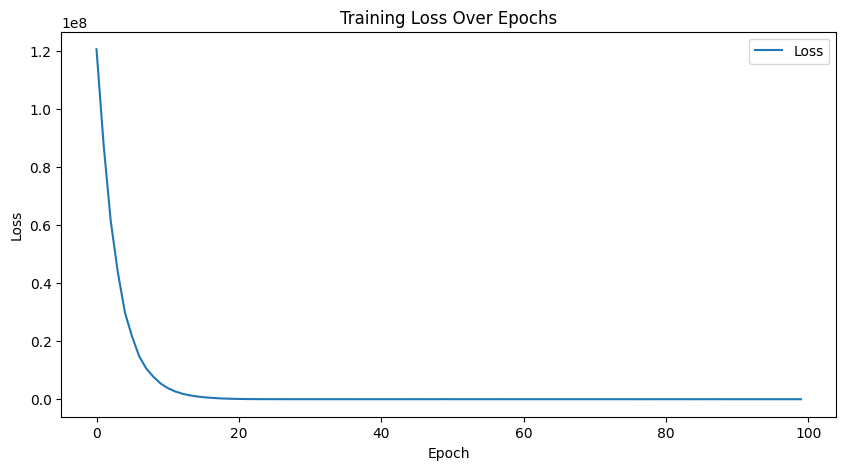

- 0.3171 + 0.7960 @ x**1 - 0.4881 @ x**2 - 0.0630 @ x**3


In [37]:
ori_data= datasets.fetch_openml('house_sales', version = 8)  # 房价数据——(21613, 15)

#ori_data_data = full_data['data'][:100]
#ori_data_target = full_data['target'][:100]
#x_data = np.array(ori_data_data, dtype=np.float32)
#y_data = np.array(ori_data_target, dtype=np.float32).reshape((-1, 1))

x_data = np.array(ori_data.data, dtype=np.float32)
y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 4

neuron = PolynomialTensorRegression(decomp_rank, 
                                    poly_order, 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [39]:
def main(seed):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('house_sales', version = 8)  # 房价数据——(21613, 15)
    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 128

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '-0.06@x**4 + 0.02@x**3 - 0.009@x**2 + 0.067@x + 0.74'

    net1 = nn.Sequential(Neurons(15, 6, sr1),
                         nn.Sigmoid(),

                         Neurons(6, 4, sr1),
                         nn.Sigmoid(),

                         Neurons(4, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.01)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k+1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

# =================================================================================================
# =================================================================================================

    random_seed(seed)
    sr2 = '- 0.3171 + 0.7960 @ x**1 - 0.4881 @ x**2 - 0.0630 @ x**3'

    net2 = nn.Sequential(Neurons(15, 8, sr2),
                         nn.Sigmoid(),

                         Neurons(8, 5, sr2),
                         nn.Sigmoid(),

                         Neurons(5, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.01)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k+1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('house_sales_' + 'result.csv', sv, delimiter=',')


run times: 1
epoch:  100  net_1_val_error:  0.009223468
epoch:  200  net_1_val_error:  0.007818882
epoch:  300  net_1_val_error:  0.007071173
net_1_test_error:  0.0069767106 

epoch:  100  net_2_val_error:  0.012166842
epoch:  200  net_2_val_error:  0.008523089
epoch:  300  net_2_val_error:  0.0073921676
net_2_test_error:  0.007137042 

run times: 2
epoch:  100  net_1_val_error:  0.007413772
epoch:  200  net_1_val_error:  0.01153219
epoch:  300  net_1_val_error:  0.0075759026
net_1_test_error:  0.008261377 

epoch:  100  net_2_val_error:  0.007228365
epoch:  200  net_2_val_error:  0.0070701647
epoch:  300  net_2_val_error:  0.009242739
net_2_test_error:  0.009436786 

run times: 3
epoch:  100  net_1_val_error:  0.008622189
epoch:  200  net_1_val_error:  0.009093667
epoch:  300  net_1_val_error:  0.007485471
net_1_test_error:  0.007831694 

epoch:  100  net_2_val_error:  0.010654962
epoch:  200  net_2_val_error:  0.008869841
epoch:  300  net_2_val_error:  0.007114208
net_2_test_error:  

## Airfoil Self Noise

d:\Anaconda\envs\task_based_neuron_env\lib\site-packages\sklearn\datasets\_openml.py:107: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/list/data_name/airfoil_self_noise/limit/2/data_version/1. Retrying...
  warn(


Epoch [10/100], Loss: 30.1937
Epoch [20/100], Loss: 17.8041
Epoch [30/100], Loss: 6.5552
Epoch [40/100], Loss: 4.6687
Epoch [50/100], Loss: 4.3079
Epoch [60/100], Loss: 4.7191
Epoch [70/100], Loss: 2.1606
Epoch [80/100], Loss: 2.6000
Epoch [90/100], Loss: 1.9410
Epoch [100/100], Loss: 2.0609


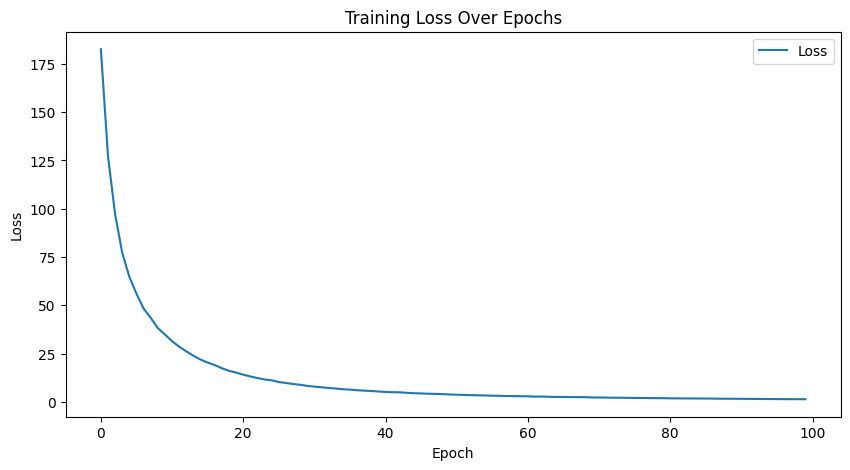

0.1540 - 1.2516 @ x**1 + 0.2047 @ x**2 - 0.6710 @ x**3


In [41]:
ori_data = datasets.fetch_openml('airfoil_self_noise', version = 1) 
x_data = np.array(ori_data.data, dtype=np.float32)
y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 4

neuron = PolynomialTensorRegression(decomp_rank, 
                                    poly_order, 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [43]:
def main(seed):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('airfoil_self_noise', version = 1)  # (1503, 5)
    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 32

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '0.06@x**2 - 0.03@x - 0.08'

    net1 = nn.Sequential(Neurons(5, 4, sr1),
                         nn.Sigmoid(),

                         Neurons(4, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k+1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

# =================================================================================================
# =================================================================================================

    random_seed(seed)
    sr2 = '0.1540 - 1.2516 @ x**1 + 0.2047 @ x**2 - 0.6710 @ x**3'

    net2 = nn.Sequential(Neurons(5, 8, sr2),
                         nn.Sigmoid(),

                         Neurons(8, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k+1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('airfoil_self_noise' + 'result.csv', sv, delimiter=',')

run times: 1
epoch:  100  net_1_val_error:  0.040749032
epoch:  200  net_1_val_error:  0.037618637
epoch:  300  net_1_val_error:  0.03595249
net_1_test_error:  0.04857246 

epoch:  100  net_2_val_error:  0.031731207
epoch:  200  net_2_val_error:  0.027181443
epoch:  300  net_2_val_error:  0.02105151
net_2_test_error:  0.028948996 

run times: 2
epoch:  100  net_1_val_error:  0.04966956
epoch:  200  net_1_val_error:  0.04533035
epoch:  300  net_1_val_error:  0.042618733
net_1_test_error:  0.050936446 

epoch:  100  net_2_val_error:  0.03742679
epoch:  200  net_2_val_error:  0.029519469
epoch:  300  net_2_val_error:  0.025669187
net_2_test_error:  0.036317814 

run times: 3
epoch:  100  net_1_val_error:  0.060617194
epoch:  200  net_1_val_error:  0.05734364
epoch:  300  net_1_val_error:  0.05575725
net_1_test_error:  0.040356897 

epoch:  100  net_2_val_error:  0.049316816
epoch:  200  net_2_val_error:  0.038017046
epoch:  300  net_2_val_error:  0.0322617
net_2_test_error:  0.025161874 


## Wine Quality Data

d:\Anaconda\envs\task_based_neuron_env\lib\site-packages\sklearn\datasets\_openml.py:107: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/43994. Retrying...
  warn(


Epoch [10/100], Loss: 402137.9062
Epoch [20/100], Loss: 81562.1406
Epoch [30/100], Loss: 109803.6719
Epoch [40/100], Loss: 45592.4688
Epoch [50/100], Loss: 283297.9688
Epoch [60/100], Loss: 355512.6562
Epoch [70/100], Loss: 238746.4531
Epoch [80/100], Loss: 110905.9609
Epoch [90/100], Loss: 254447.7969
Epoch [100/100], Loss: 67600.5234


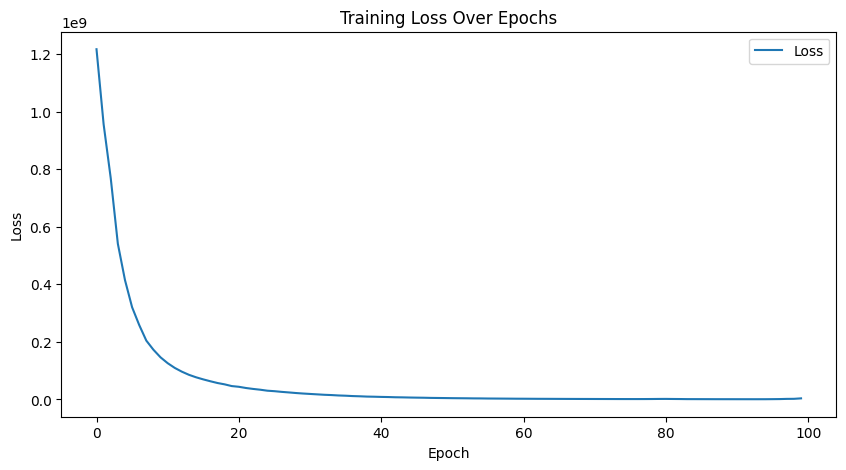

1.3568 + 2.2984 @ x**1 - 2.0348 @ x**2 - 0.9222 @ x**3 - 0.6930 @ x**5


In [44]:
ori_data = datasets.fetch_openml('wine_quality', version = 4) 
x_data = np.array(ori_data.data, dtype=np.float32)
y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 5

neuron = PolynomialTensorRegression(decomp_rank, 
                                    poly_order, 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [46]:
def main(seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('wine_quality', version = 4)  # (6497, 11)
    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 64

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '0.007@x**4 + 0.05@x**3 + 0.1@x**2 + 0.05@x - 0.0003'

    net1 = nn.Sequential(Neurons(11, 6, sr1),
                         nn.Sigmoid(),

                         Neurons(6, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

    # =================================================================================================
    # =================================================================================================

    random_seed(seed)
    sr2 = '1.3568 + 2.2984 @ x**1 - 2.0348 @ x**2 - 0.9222 @ x**3 - 0.6930 @ x**5'

    net2 = nn.Sequential(Neurons(11, 9, sr2),
                         nn.Sigmoid(),

                         Neurons(9, 5, sr2),
                         nn.Sigmoid(),

                         Neurons(5, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('wine_quality_' + 'result.csv', sv, delimiter=',')

run times: 1
epoch:  100  net_1_val_error:  0.058661144
epoch:  200  net_1_val_error:  0.0575236
epoch:  300  net_1_val_error:  0.05688074
net_1_test_error:  0.053813986 

epoch:  100  net_2_val_error:  0.059966043
epoch:  200  net_2_val_error:  0.0564327
epoch:  300  net_2_val_error:  0.05719136
net_2_test_error:  0.054341506 

run times: 2
epoch:  100  net_1_val_error:  0.05265204
epoch:  200  net_1_val_error:  0.051936988
epoch:  300  net_1_val_error:  0.051683497
net_1_test_error:  0.054849148 

epoch:  100  net_2_val_error:  0.051878422
epoch:  200  net_2_val_error:  0.05352261
epoch:  300  net_2_val_error:  0.053586964
net_2_test_error:  0.05455138 

run times: 3
epoch:  100  net_1_val_error:  0.05744039
epoch:  200  net_1_val_error:  0.055709723
epoch:  300  net_1_val_error:  0.057394493
net_1_test_error:  0.051914472 

epoch:  100  net_2_val_error:  0.05547537
epoch:  200  net_2_val_error:  0.055261716
epoch:  300  net_2_val_error:  0.054178406
net_2_test_error:  0.0521842 

ru

Epoch [10/100], Loss: 4956.2139
Epoch [20/100], Loss: 14128.6240
Epoch [30/100], Loss: 64599.5000
Epoch [40/100], Loss: 40353.3828
Epoch [50/100], Loss: 1372.1027
Epoch [60/100], Loss: 3863.2183
Epoch [70/100], Loss: 27172.9023
Epoch [80/100], Loss: 2905.3511
Epoch [90/100], Loss: 21686.7871
Epoch [100/100], Loss: 239.1139


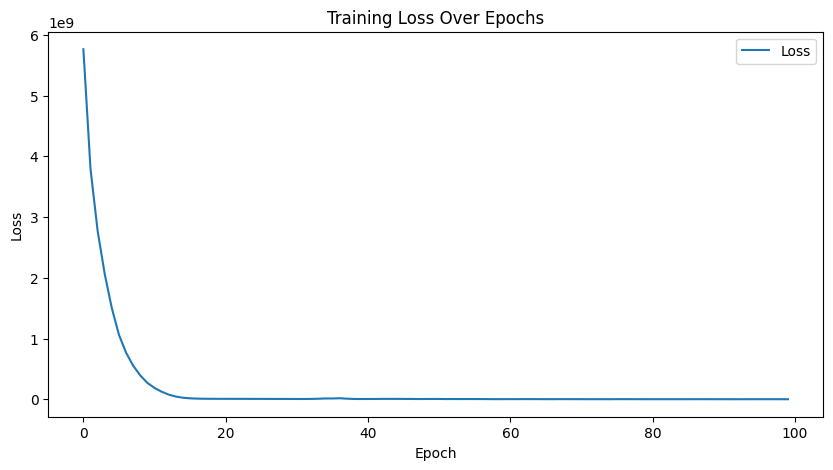

2.3879 - 1.3375 @ x**1 + 1.1275 @ x**2 - 0.7373 @ x**4 - 0.6707 @ x**5


In [47]:
ori_data = datasets.fetch_openml('fifa', version = 2)  # (18063, 5)
x_data = np.array(ori_data.data, dtype=np.float32)
y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 5

neuron = PolynomialTensorRegression(decomp_rank, 
                                    poly_order, 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [50]:
def main(seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('fifa', version = 2)  # (18063, 5)
    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 600
    batch_size = 128

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '0.2@x**5 - 0.6@x**4 - 0.1@x**3 + 0.3@x**2 + 0.1@x + 0.009'

    net1 = nn.Sequential(Neurons(5, 3, sr1),
                         nn.Sigmoid(),

                         Neurons(3, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.005)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

    # =================================================================================================
    # =================================================================================================

    random_seed(seed)
    sr2 = '2.387 - 1.337 @ x**1 + 1.127 @ x**2 - 0.737 @ x**4 - 0.671 @ x**5'

    net2 = nn.Sequential(Neurons(5, 5, sr2),
                         nn.Sigmoid(),

                         Neurons(5, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.005)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('fifa_' + 'result.csv', sv, delimiter=',')

run times: 1
epoch:  100  net_1_val_error:  0.06623991
epoch:  200  net_1_val_error:  0.07232715
epoch:  300  net_1_val_error:  0.06869271
epoch:  400  net_1_val_error:  0.062479805
epoch:  500  net_1_val_error:  0.06176464
epoch:  600  net_1_val_error:  0.06849959
net_1_test_error:  0.06554239 

epoch:  100  net_2_val_error:  0.06285556
epoch:  200  net_2_val_error:  0.06998664
epoch:  300  net_2_val_error:  0.06194394
epoch:  400  net_2_val_error:  0.061049797
epoch:  500  net_2_val_error:  0.06342706
epoch:  600  net_2_val_error:  0.060900353
net_2_test_error:  0.058967408 

run times: 2
epoch:  100  net_1_val_error:  0.06677572
epoch:  200  net_1_val_error:  0.06176164
epoch:  300  net_1_val_error:  0.06375117
epoch:  400  net_1_val_error:  0.06079313
epoch:  500  net_1_val_error:  0.060916077
epoch:  600  net_1_val_error:  0.062145688
net_1_test_error:  0.0632735 

epoch:  100  net_2_val_error:  0.063289985
epoch:  200  net_2_val_error:  0.068602875
epoch:  300  net_2_val_error:  

## Diamond data


Epoch [10/100], Loss: 26244614.0000
Epoch [20/100], Loss: 4549007.5000
Epoch [30/100], Loss: 1720773.6250
Epoch [40/100], Loss: 1335130.5000
Epoch [50/100], Loss: 742972.6250
Epoch [60/100], Loss: 402220.6562
Epoch [70/100], Loss: 238611.0312
Epoch [80/100], Loss: 148963.5781
Epoch [90/100], Loss: 28651.8008
Epoch [100/100], Loss: 1768585.6250


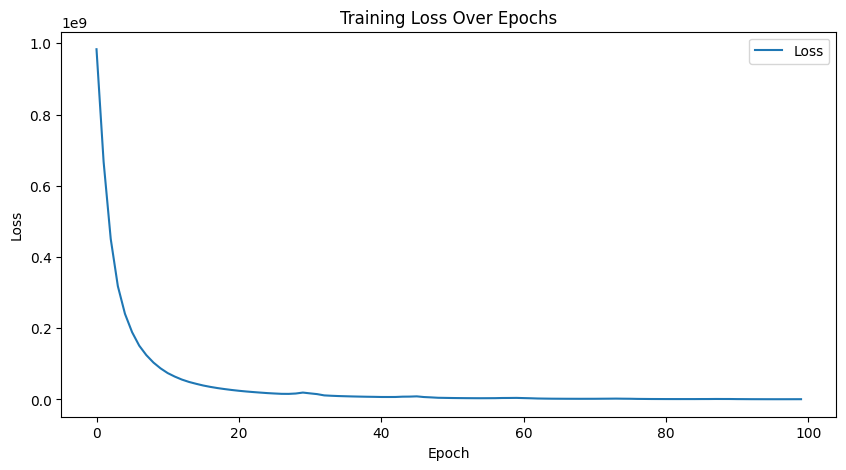

1.2588 - 2.2481 @ x**1 + 2.9706 @ x**2 + 1.3841 @ x**3 - 1.2817 @ x**4 + 1.0816 @ x**5 - 0.4426 @ x**7


In [8]:
ori_data = datasets.fetch_openml('diamonds', version=1, as_frame=True)

# 随机选择 8000 个数据点
ori_data_df = ori_data.data  # 获取 DataFrame 格式的特征数据
ori_data_df['price'] = ori_data.target  # 添加目标变量

ori_data_df = ori_data_df.sample(n=8000, random_state=42).reset_index(drop=True)

# 将类别型变量转换为浮点数
ori_data_df['cut'] = pd.factorize(ori_data_df['cut'])[0].astype(float) + 1
ori_data_df['color'] = pd.factorize(ori_data_df['color'])[0].astype(float) + 1
ori_data_df['clarity'] = pd.factorize(ori_data_df['clarity'])[0].astype(float) + 1

# 将数据转换为 numpy 数组
x_data = np.array(ori_data_df.drop(columns='price'), dtype=np.float32)
y_data = np.array(ori_data_df['price'], dtype=np.float32).reshape((-1, 1))

# 标准化数据
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)

# 设置 CP 分解的秩和多项式阶数
decomp_rank = 2
poly_order = 7

# 初始化并训练模型
neuron = PolynomialTensorRegression(decomp_rank, 
                                    poly_order, 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data, y_data, view_training_process=True) 
print(neuron.neuron)

In [13]:
def main(seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('diamonds', version=1)  # (53940, 9)
    ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
    ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
    ori_data.data['clarity'] = pd.factorize(ori_data.data['clarity'])[0].astype(float) + 1

    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 512

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '-0.07@x**7 + 0.1@x**6 + 0.1@x**5 - 0.2@x**4 + 0.09@x**3'

    net1 = nn.Sequential(Neurons(9, 4, sr1),
                         nn.Sigmoid(),

                         Neurons(4, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

    # =================================================================================================
    # =================================================================================================

    random_seed(seed)
    sr2 = '1.25 - 2.24 @ x**1 + 2.97 @ x**2 + 1.38 @ x**3 - 1.28 @ x**4 + 1.08 @ x**5 - 0.44 @ x**7'

    net2 = nn.Sequential(Neurons(9, 7, sr2),
                         nn.Sigmoid(),

                         Neurons(7, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(8):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('diamonds_' + 'result.csv', sv, delimiter=',')

run times: 1


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.01530947
epoch:  200  net_1_val_error:  0.016874198
epoch:  300  net_1_val_error:  0.018048964
net_1_test_error:  0.010571733 

epoch:  100  net_2_val_error:  0.013713167
epoch:  200  net_2_val_error:  0.02055945
epoch:  300  net_2_val_error:  0.021961018
net_2_test_error:  0.005923556 

run times: 2


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.010807098
epoch:  200  net_1_val_error:  0.009960143
epoch:  300  net_1_val_error:  0.009685425
net_1_test_error:  0.00866627 

epoch:  100  net_2_val_error:  0.0067001474
epoch:  200  net_2_val_error:  0.005251015
epoch:  300  net_2_val_error:  0.0045108013
net_2_test_error:  0.0044157435 

run times: 3


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.030407876
epoch:  200  net_1_val_error:  0.03908186
epoch:  300  net_1_val_error:  0.043801084
net_1_test_error:  0.008882549 

epoch:  100  net_2_val_error:  0.022937689
epoch:  200  net_2_val_error:  0.038877483
epoch:  300  net_2_val_error:  0.05204932
net_2_test_error:  0.004981284 

run times: 4


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.010251128
epoch:  200  net_1_val_error:  0.00954084
epoch:  300  net_1_val_error:  0.008995215
net_1_test_error:  0.008804002 

epoch:  100  net_2_val_error:  0.007183292
epoch:  200  net_2_val_error:  0.008387028
epoch:  300  net_2_val_error:  0.016163263
net_2_test_error:  0.018475657 

run times: 5


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.011801627
epoch:  200  net_1_val_error:  0.009864844
epoch:  300  net_1_val_error:  0.010012807
net_1_test_error:  0.010199641 

epoch:  100  net_2_val_error:  0.006910664
epoch:  200  net_2_val_error:  0.0051543987
epoch:  300  net_2_val_error:  0.0047676926
net_2_test_error:  0.0044196914 

run times: 6


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.011531259
epoch:  200  net_1_val_error:  0.010527189
epoch:  300  net_1_val_error:  0.009923829
net_1_test_error:  0.021169791 

epoch:  100  net_2_val_error:  0.0066265943
epoch:  200  net_2_val_error:  0.0048903287
epoch:  300  net_2_val_error:  0.0043583727
net_2_test_error:  0.05722801 

run times: 7


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.009363604
epoch:  200  net_1_val_error:  0.0090217525
epoch:  300  net_1_val_error:  0.00879168
net_1_test_error:  0.009162404 

epoch:  100  net_2_val_error:  0.008000943
epoch:  200  net_2_val_error:  0.005079533
epoch:  300  net_2_val_error:  0.0046037817
net_2_test_error:  0.004709719 

run times: 8


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['cut'] = pd.factorize(ori_data.data['cut'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['color'] = pd.factorize(ori_data.data['color'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_11268\318599382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

epoch:  100  net_1_val_error:  0.011645094
epoch:  200  net_1_val_error:  0.010286446
epoch:  300  net_1_val_error:  0.009890356
net_1_test_error:  0.010988111 

epoch:  100  net_2_val_error:  0.0068787336
epoch:  200  net_2_val_error:  0.0052075507
epoch:  300  net_2_val_error:  0.0048643923
net_2_test_error:  0.0054030945 



## abalone

C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1675129120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


Epoch [10/100], Loss: 2320.0691
Epoch [20/100], Loss: 301.1734
Epoch [30/100], Loss: 154.7773
Epoch [40/100], Loss: 216.1820
Epoch [50/100], Loss: 138.9207
Epoch [60/100], Loss: 123.1645
Epoch [70/100], Loss: 668.5857
Epoch [80/100], Loss: 152.2697
Epoch [90/100], Loss: 105.4542
Epoch [100/100], Loss: 746.5728


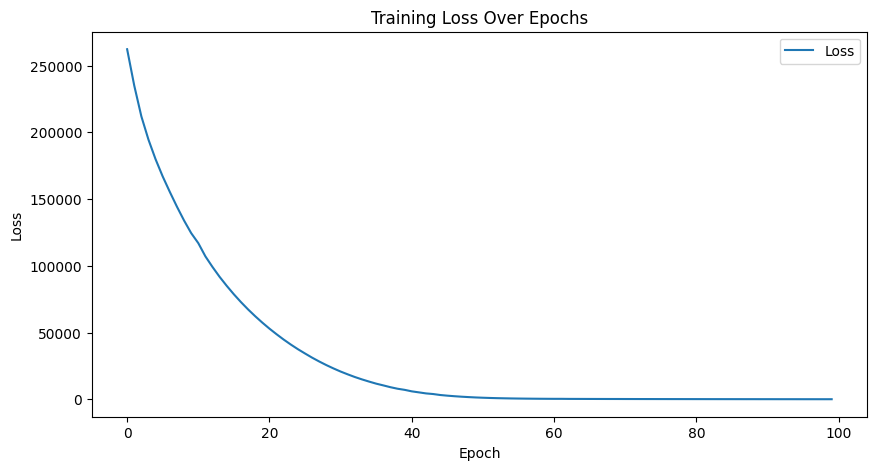

1.2607 - 0.5903 @ x**1 + 0.8600 @ x**2 - 1.8105 @ x**3


In [19]:
ori_data = datasets.fetch_openml('abalone', version = 5)  # (18063, 5)
ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1
x_data = np.array(ori_data.data, dtype=np.float32)
y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 3

neuron = PolynomialTensorRegression(decomp_rank , 
                                    poly_order , 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [20]:
def main(seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('abalone', version=5)  # (4177, 8)
    ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1

    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 32

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '-0.08@x**3 - 0.1@x**2 + 0.04@x'

    net1 = nn.Sequential(Neurons(8, 5, sr1),
                         nn.Sigmoid(),

                         Neurons(5, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

    # =================================================================================================
    # =================================================================================================

    random_seed(seed)
    sr2 = '1.2607 - 0.5903 @ x**1 + 0.8600 @ x**2 - 1.8105 @ x**3'

    net2 = nn.Sequential(Neurons(8, 8, sr2),
                         nn.Sigmoid(),

                         Neurons(8, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('abalone_' + 'result.csv', sv, delimiter=',')

run times: 1


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.02236162
epoch:  200  net_1_val_error:  0.02276776
epoch:  300  net_1_val_error:  0.022599734
net_1_test_error:  0.020833613 

epoch:  100  net_2_val_error:  0.023326583
epoch:  200  net_2_val_error:  0.023004469
epoch:  300  net_2_val_error:  0.0226805
net_2_test_error:  0.020666115 

run times: 2


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.022928637
epoch:  200  net_1_val_error:  0.02226779
epoch:  300  net_1_val_error:  0.021460239
net_1_test_error:  0.028307669 

epoch:  100  net_2_val_error:  0.021874622
epoch:  200  net_2_val_error:  0.021273931
epoch:  300  net_2_val_error:  0.021294536
net_2_test_error:  0.028452989 

run times: 3


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.022297315
epoch:  200  net_1_val_error:  0.0219618
epoch:  300  net_1_val_error:  0.021749523
net_1_test_error:  0.024619384 

epoch:  100  net_2_val_error:  0.02208336
epoch:  200  net_2_val_error:  0.021903213
epoch:  300  net_2_val_error:  0.022059742
net_2_test_error:  0.02467685 

run times: 4


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.019818787
epoch:  200  net_1_val_error:  0.020207733
epoch:  300  net_1_val_error:  0.020723848
net_1_test_error:  0.02250071 

epoch:  100  net_2_val_error:  0.019802822
epoch:  200  net_2_val_error:  0.018937593
epoch:  300  net_2_val_error:  0.019039337
net_2_test_error:  0.02103674 

run times: 5


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.020935506
epoch:  200  net_1_val_error:  0.020624623
epoch:  300  net_1_val_error:  0.020458741
net_1_test_error:  0.023247005 

epoch:  100  net_2_val_error:  0.023054348
epoch:  200  net_2_val_error:  0.020809624
epoch:  300  net_2_val_error:  0.020911956
net_2_test_error:  0.02387876 

run times: 6


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.021622794
epoch:  200  net_1_val_error:  0.021137616
epoch:  300  net_1_val_error:  0.021063166
net_1_test_error:  0.021001948 

epoch:  100  net_2_val_error:  0.02150956
epoch:  200  net_2_val_error:  0.020723235
epoch:  300  net_2_val_error:  0.020546218
net_2_test_error:  0.020447867 

run times: 7


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.018155929
epoch:  200  net_1_val_error:  0.0172849
epoch:  300  net_1_val_error:  0.01730139
net_1_test_error:  0.024648663 

epoch:  100  net_2_val_error:  0.016981198
epoch:  200  net_2_val_error:  0.018352188
epoch:  300  net_2_val_error:  0.018006623
net_2_test_error:  0.023874605 

run times: 8


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.02467818
epoch:  200  net_1_val_error:  0.02444163
epoch:  300  net_1_val_error:  0.023690846
net_1_test_error:  0.02456284 

epoch:  100  net_2_val_error:  0.023839207
epoch:  200  net_2_val_error:  0.023468778
epoch:  300  net_2_val_error:  0.023924652
net_2_test_error:  0.02560553 

run times: 9


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.028201044
epoch:  200  net_1_val_error:  0.02877527
epoch:  300  net_1_val_error:  0.027514609
net_1_test_error:  0.027463023 

epoch:  100  net_2_val_error:  0.027680265
epoch:  200  net_2_val_error:  0.027462756
epoch:  300  net_2_val_error:  0.027569382
net_2_test_error:  0.027429914 

run times: 10


C:\Users\94336\AppData\Local\Temp\ipykernel_11268\1455426643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['Sex'] = pd.factorize(ori_data.data['Sex'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.020609796
epoch:  200  net_1_val_error:  0.019987341
epoch:  300  net_1_val_error:  0.020669252
net_1_test_error:  0.02208948 

epoch:  100  net_2_val_error:  0.020430274
epoch:  200  net_2_val_error:  0.019839074
epoch:  300  net_2_val_error:  0.019845482
net_2_test_error:  0.021719486 



## Bike Sharing Demand Data

C:\Users\94336\AppData\Local\Temp\ipykernel_22908\3277811889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\3277811889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


Epoch [10/100], Loss: 312.8532
Epoch [20/100], Loss: 25.0864
Epoch [30/100], Loss: 1.7753
Epoch [40/100], Loss: 0.8282
Epoch [50/100], Loss: 0.4256
Epoch [60/100], Loss: 0.5170
Epoch [70/100], Loss: 0.5254
Epoch [80/100], Loss: 0.3826
Epoch [90/100], Loss: 0.3717
Epoch [100/100], Loss: 0.4635


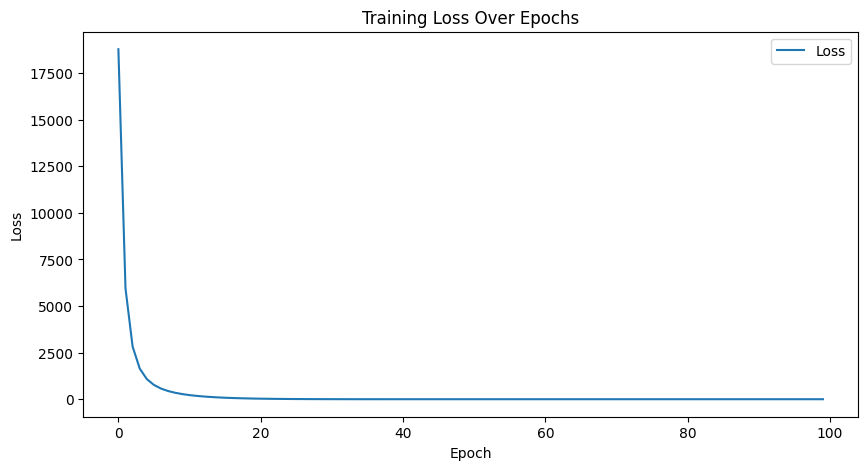

0.3258 + 0.1083 @ x**1 + 0.0748 @ x**2


In [3]:
ori_data = datasets.fetch_openml('Bike_Sharing_Demand', version=3)  # (17379, 12)
ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1
x_data = np.array(ori_data.data, dtype=np.float32)
y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 3

neuron = PolynomialTensorRegression(decomp_rank , 
                                    poly_order , 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [5]:
def main(seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('Bike_Sharing_Demand', version=3)  # (17379, 12)
    ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
    ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1

    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 500
    batch_size = 256

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '-0.08@x**2 + 0.05@x + 0.0002'

    net1 = nn.Sequential(Neurons(12, 8, sr1),
                         nn.Sigmoid(),

                         Neurons(8, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

    # =================================================================================================
    # =================================================================================================

    random_seed(seed)
    sr2 = '0.3258 + 0.1083 @ x**1 + 0.0748 @ x**2'

    net2 = nn.Sequential(Neurons(12, 10, sr2),
                         nn.Sigmoid(),

                         Neurons(10, 8, sr2),
                         nn.Sigmoid(),

                         Neurons(8, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('Bike_Sharing_Demand_' + 'result.csv', sv, delimiter=',')

run times: 1


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.047602504
epoch:  200  net_1_val_error:  0.037658997
epoch:  300  net_1_val_error:  0.02505597
epoch:  400  net_1_val_error:  0.020232089
epoch:  500  net_1_val_error:  0.017540593
net_1_test_error:  0.017238319 

epoch:  100  net_2_val_error:  0.043130666
epoch:  200  net_2_val_error:  0.027896948
epoch:  300  net_2_val_error:  0.01929431
epoch:  400  net_2_val_error:  0.016845377
epoch:  500  net_2_val_error:  0.014869373
net_2_test_error:  0.013993045 

run times: 2


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.04523444
epoch:  200  net_1_val_error:  0.031255994
epoch:  300  net_1_val_error:  0.021435741
epoch:  400  net_1_val_error:  0.01969711
epoch:  500  net_1_val_error:  0.017892037
net_1_test_error:  0.019136326 

epoch:  100  net_2_val_error:  0.03980595
epoch:  200  net_2_val_error:  0.024149368
epoch:  300  net_2_val_error:  0.017907681
epoch:  400  net_2_val_error:  0.014510757
epoch:  500  net_2_val_error:  0.012158646
net_2_test_error:  0.0134046115 

run times: 3


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.04815534
epoch:  200  net_1_val_error:  0.0286569
epoch:  300  net_1_val_error:  0.019917358
epoch:  400  net_1_val_error:  0.016613571
epoch:  500  net_1_val_error:  0.014464264
net_1_test_error:  0.015079915 

epoch:  100  net_2_val_error:  0.04084289
epoch:  200  net_2_val_error:  0.022958444
epoch:  300  net_2_val_error:  0.016900843
epoch:  400  net_2_val_error:  0.013267193
epoch:  500  net_2_val_error:  0.01176995
net_2_test_error:  0.011583026 

run times: 4


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.0485516
epoch:  200  net_1_val_error:  0.02548799
epoch:  300  net_1_val_error:  0.01961022
epoch:  400  net_1_val_error:  0.01793688
epoch:  500  net_1_val_error:  0.017221108
net_1_test_error:  0.016311178 

epoch:  100  net_2_val_error:  0.04189239
epoch:  200  net_2_val_error:  0.02431151
epoch:  300  net_2_val_error:  0.017128186
epoch:  400  net_2_val_error:  0.015208136
epoch:  500  net_2_val_error:  0.013813843
net_2_test_error:  0.013156287 

run times: 5


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.050790194
epoch:  200  net_1_val_error:  0.026623935
epoch:  300  net_1_val_error:  0.019532464
epoch:  400  net_1_val_error:  0.017776106
epoch:  500  net_1_val_error:  0.016528802
net_1_test_error:  0.01761109 

epoch:  100  net_2_val_error:  0.042738732
epoch:  200  net_2_val_error:  0.024443872
epoch:  300  net_2_val_error:  0.017337358
epoch:  400  net_2_val_error:  0.0150125
epoch:  500  net_2_val_error:  0.012239149
net_2_test_error:  0.012469134 

run times: 6


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.04580474
epoch:  200  net_1_val_error:  0.030385636
epoch:  300  net_1_val_error:  0.025138075
epoch:  400  net_1_val_error:  0.021903483
epoch:  500  net_1_val_error:  0.020048862
net_1_test_error:  0.022159409 

epoch:  100  net_2_val_error:  0.03836823
epoch:  200  net_2_val_error:  0.020710919
epoch:  300  net_2_val_error:  0.014510247
epoch:  400  net_2_val_error:  0.011871015
epoch:  500  net_2_val_error:  0.0106850695
net_2_test_error:  0.012676629 

run times: 7


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.048651606
epoch:  200  net_1_val_error:  0.04221295
epoch:  300  net_1_val_error:  0.02980906
epoch:  400  net_1_val_error:  0.021640792
epoch:  500  net_1_val_error:  0.019523721
net_1_test_error:  0.021341944 

epoch:  100  net_2_val_error:  0.0422288
epoch:  200  net_2_val_error:  0.022886416
epoch:  300  net_2_val_error:  0.018428292
epoch:  400  net_2_val_error:  0.014523334
epoch:  500  net_2_val_error:  0.013007702
net_2_test_error:  0.014471208 

run times: 8


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.04574076
epoch:  200  net_1_val_error:  0.034339603
epoch:  300  net_1_val_error:  0.022376437
epoch:  400  net_1_val_error:  0.018646514
epoch:  500  net_1_val_error:  0.017283995
net_1_test_error:  0.016399354 

epoch:  100  net_2_val_error:  0.04155141
epoch:  200  net_2_val_error:  0.021846162
epoch:  300  net_2_val_error:  0.016336972
epoch:  400  net_2_val_error:  0.0142212175
epoch:  500  net_2_val_error:  0.013274999
net_2_test_error:  0.013678786 

run times: 9


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.05116294
epoch:  200  net_1_val_error:  0.03602704
epoch:  300  net_1_val_error:  0.025630986
epoch:  400  net_1_val_error:  0.02001736
epoch:  500  net_1_val_error:  0.01767742
net_1_test_error:  0.016732633 

epoch:  100  net_2_val_error:  0.031003818
epoch:  200  net_2_val_error:  0.014823046
epoch:  300  net_2_val_error:  0.011435715
epoch:  400  net_2_val_error:  0.009869283
epoch:  500  net_2_val_error:  0.010327631
net_2_test_error:  0.009902328 

run times: 10


C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['season'] = pd.factorize(ori_data.data['season'])[0].astype(float) + 1
C:\Users\94336\AppData\Local\Temp\ipykernel_22908\1110720935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori_data.data['weather'] = pd.factorize(ori_data.data['weather'])[0].astype(float) + 1


epoch:  100  net_1_val_error:  0.047346905
epoch:  200  net_1_val_error:  0.027686484
epoch:  300  net_1_val_error:  0.021241646
epoch:  400  net_1_val_error:  0.018396858
epoch:  500  net_1_val_error:  0.01623869
net_1_test_error:  0.014784548 

epoch:  100  net_2_val_error:  0.044822533
epoch:  200  net_2_val_error:  0.022160215
epoch:  300  net_2_val_error:  0.014881763
epoch:  400  net_2_val_error:  0.0117119355
epoch:  500  net_2_val_error:  0.010313179
net_2_test_error:  0.009987824 



## Space_ga Data

Epoch [10/100], Loss: 541.0325
Epoch [20/100], Loss: 443.6266
Epoch [30/100], Loss: 223.1939
Epoch [40/100], Loss: 81.5181
Epoch [50/100], Loss: 45.0918
Epoch [60/100], Loss: 63.8552
Epoch [70/100], Loss: 43.2221
Epoch [80/100], Loss: 35.3144
Epoch [90/100], Loss: 37.9549
Epoch [100/100], Loss: 32.8580


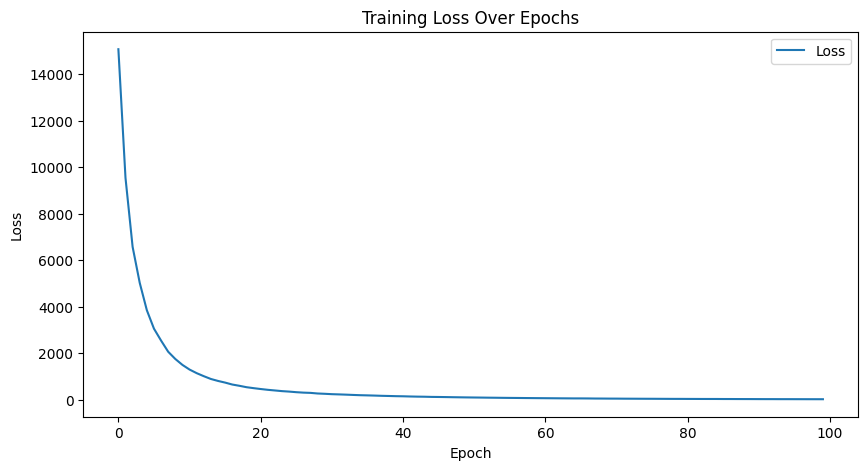

1.0408 + 0.2180 @ x**1 + 0.9379 @ x**2 - 1.0504 @ x**4 - 0.1811 @ x**5


In [8]:
ori_data = datasets.fetch_openml('space_ga', version=5)  # (3107, 6)  

x_data = np.array(ori_data.data, dtype=np.float32)
y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 5

neuron = PolynomialTensorRegression(decomp_rank , 
                                    poly_order , 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [9]:
def main(seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('space_ga', version=5)  # (3107, 6)

    x_data = np.array(ori_data.data, dtype=np.float32)
    y_data = np.array(ori_data.target, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 16

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '0.05@x**4 + 0.1@x**3 + 0.02@x**2 - 0.07@x + 0.5'

    net1 = nn.Sequential(Neurons(6, 2, sr1),
                         nn.Sigmoid(),

                         Neurons(2, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

    # =================================================================================================
    # =================================================================================================

    random_seed(seed)
    sr2 = '1.0408 + 0.2180 @ x**1 + 0.9379 @ x**2 - 1.0504 @ x**4 - 0.1811 @ x**5'

    net2 = nn.Sequential(Neurons(6, 3, sr2),
                         nn.Sigmoid(),

                         Neurons(3, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('space_ga_' + 'result.csv', sv, delimiter=',')


run times: 1
epoch:  100  net_1_val_error:  0.0048836498
epoch:  200  net_1_val_error:  0.004442271
epoch:  300  net_1_val_error:  0.0046915803
net_1_test_error:  0.0047866073 

epoch:  100  net_2_val_error:  0.00455292
epoch:  200  net_2_val_error:  0.004457618
epoch:  300  net_2_val_error:  0.0042016543
net_2_test_error:  0.004484758 

run times: 2
epoch:  100  net_1_val_error:  0.0056724837
epoch:  200  net_1_val_error:  0.005126644
epoch:  300  net_1_val_error:  0.0052982057
net_1_test_error:  0.006022169 

epoch:  100  net_2_val_error:  0.0054213614
epoch:  200  net_2_val_error:  0.005153247
epoch:  300  net_2_val_error:  0.005145511
net_2_test_error:  0.0055350964 

run times: 3
epoch:  100  net_1_val_error:  0.007385361
epoch:  200  net_1_val_error:  0.005700108
epoch:  300  net_1_val_error:  0.0052926065
net_1_test_error:  0.0039212373 

epoch:  100  net_2_val_error:  0.0068101212
epoch:  200  net_2_val_error:  0.0060530724
epoch:  300  net_2_val_error:  0.0055331606
net_2_test

## Airlines Data

Epoch [10/100], Loss: 1225.2494
Epoch [20/100], Loss: 355.5378
Epoch [30/100], Loss: 245.1920
Epoch [40/100], Loss: 43.6923
Epoch [50/100], Loss: 45.7215
Epoch [60/100], Loss: 49.1725
Epoch [70/100], Loss: 13.2978
Epoch [80/100], Loss: 2.9602
Epoch [90/100], Loss: 1.9109
Epoch [100/100], Loss: 1.1047


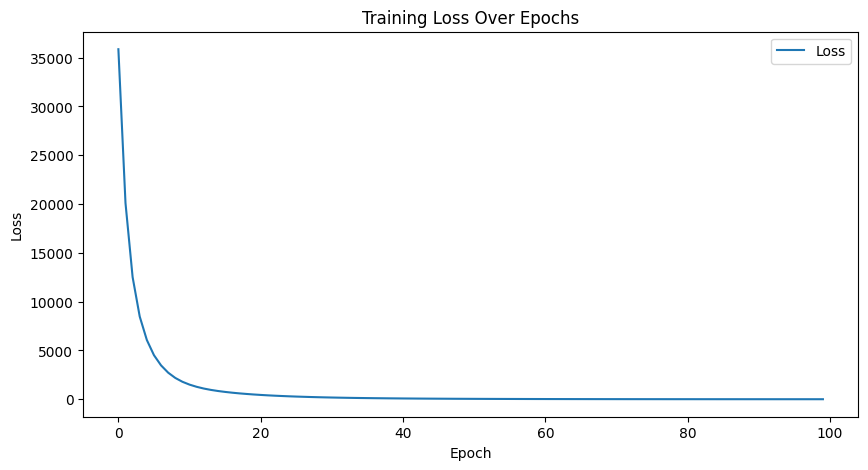

0.2295 + 0.1032 @ x**1 + 0.2720 @ x**2 + 0.1720 @ x**4


In [10]:
ori_data = datasets.fetch_openml('Airlines_DepDelay_1M', version=6)  
cat = pd.concat([ori_data.data, ori_data.target], axis=1)
smp = cat.sample(n=8000, random_state=10)
X_all_ = smp[['Month', 'DayofMonth', 'CRSDepTime', 'CRSArrTime', 'Distance']]
y_all_ = smp['DepDelay']

x_data = np.array(X_all_, dtype=np.float32)
y_data = np.array(y_all_, dtype=np.float32).reshape((-1, 1))

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
y_data = scaler.fit_transform(y_data)
decomp_rank = 3
poly_order = 4

neuron = PolynomialTensorRegression(decomp_rank , 
                                    poly_order , 
                                    method='cp', 
                                    reg_lambda_w=0.01, 
                                    reg_lambda_c=0.01
                                    ) 

neuron.fit(x_data,y_data,view_training_process=True) 
print(neuron.neuron)

In [11]:
def main(seed):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ori_data = datasets.fetch_openml('Airlines_DepDelay_1M', version=6)  # (1000000, 5)
    cat = pd.concat([ori_data.data, ori_data.target], axis=1)
    smp = cat.sample(n=8000, random_state=10)
    X_all_ = smp[['Month', 'DayofMonth', 'CRSDepTime', 'CRSArrTime', 'Distance']]
    y_all_ = smp['DepDelay']

    x_data = np.array(X_all_, dtype=np.float32)
    y_data = np.array(y_all_, dtype=np.float32).reshape((-1, 1))

    train_x, x_test, train_y, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
    x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    x_train = ny2tensor(scaler_x.fit_transform(x_train))
    x_valid = ny2tensor(scaler_x.transform(x_valid))
    x_test = ny2tensor(scaler_x.transform(x_test))

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train = ny2tensor(scaler_y.fit_transform(y_train))
    y_valid = ny2tensor(scaler_y.transform(y_valid))
    y_test = ny2tensor(scaler_y.transform(y_test))

    max_epoch = 300
    batch_size = 256

    trainset = MyData(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # =======================================================================================================

    random_seed(seed)
    sr1 = '0.01@x**2 + 0.04@x - 0.2'

    net1 = nn.Sequential(Neurons(5, 4, sr1),
                         nn.Sigmoid(),

                         Neurons(4, 1, sr1),
                         ).to(device)

    cost1 = nn.MSELoss().to(device)
    optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.001)

    initial_score1 = float("inf")

    for k in range(max_epoch):
        for inputs1, labels1 in trainloader:
            inputs1 = inputs1.to(device)
            labels1 = labels1.to(device)
            predict1 = net1(inputs1)
            loss1 = cost1(predict1, labels1)
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        # validation
        with torch.no_grad():
            error1 = mean_squared_error(net1(x_valid.to(device)).cpu(), y_valid)
            if error1 < initial_score1:
                initial_score1 = error1
                model_best1 = net1

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_1_val_error: ', error1)

    # prediction
    with torch.no_grad():
        test_error1 = mean_squared_error(model_best1(x_test.to(device)).cpu(), y_test)

    print('net_1_test_error: ', test_error1, '\n')

    # =================================================================================================
    # =================================================================================================

    random_seed(seed)
    sr2 = '0.2295 + 0.1032 @ x**1 + 0.2720 @ x**2 + 0.1720 @ x**4'

    net2 = nn.Sequential(Neurons(5, 8, sr2),
                         nn.Sigmoid(),

                         Neurons(8, 1, sr2),
                         ).to(device)

    cost2 = nn.MSELoss().to(device)
    optimizer2 = torch.optim.RMSprop(net2.parameters(), lr=0.001)

    initial_score2 = float("inf")

    for k in range(max_epoch):
        for inputs2, labels2 in trainloader:
            inputs2 = inputs2.to(device)
            labels2 = labels2.to(device)
            predict2 = net2(inputs2)
            loss2 = cost2(predict2, labels2)
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()

        # validation
        with torch.no_grad():
            error2 = mean_squared_error(net2(x_valid.to(device)).cpu(), y_valid)
            if error2 < initial_score2:
                initial_score2 = error2
                model_best2 = net2

        if (k + 1) % 100 == 0:
            print('epoch: ', k + 1, ' net_2_val_error: ', error2)

    # prediction
    with torch.no_grad():
        test_error2 = mean_squared_error(model_best2(x_test.to(device)).cpu(), y_test)

    print('net_2_test_error: ', test_error2, '\n')

    return test_error1, test_error2


if __name__ == '__main__':

    error1_list = []
    error2_list = []
    sv = np.empty((1, 4))

    for i in range(10):
        print('run times:', i + 1)
        error_1, error_2 = main(i + 1)

        error1_list.append(error_1)
        error2_list.append(error_2)

    sv[0, 0] = np.mean(error1_list)
    sv[0, 1] = np.std(error1_list)

    sv[0, 2] = np.mean(error2_list)
    sv[0, 3] = np.std(error2_list)

    np.savetxt('Airlines_DepDelay_' + 'result.csv', sv, delimiter=',')

run times: 1
epoch:  100  net_1_val_error:  0.18354863
epoch:  200  net_1_val_error:  0.18324994
epoch:  300  net_1_val_error:  0.18285377
net_1_test_error:  0.16786958 

epoch:  100  net_2_val_error:  0.18344264
epoch:  200  net_2_val_error:  0.18308838
epoch:  300  net_2_val_error:  0.18265937
net_2_test_error:  0.16792476 

run times: 2
epoch:  100  net_1_val_error:  0.17054611
epoch:  200  net_1_val_error:  0.17015709
epoch:  300  net_1_val_error:  0.16994242
net_1_test_error:  0.17337658 

epoch:  100  net_2_val_error:  0.1693096
epoch:  200  net_2_val_error:  0.16942741
epoch:  300  net_2_val_error:  0.1692153
net_2_test_error:  0.1728374 

run times: 3
epoch:  100  net_1_val_error:  0.15955785
epoch:  200  net_1_val_error:  0.15922388
epoch:  300  net_1_val_error:  0.1592688
net_1_test_error:  0.16007966 

epoch:  100  net_2_val_error:  0.15986608
epoch:  200  net_2_val_error:  0.15975466
epoch:  300  net_2_val_error:  0.16028295
net_2_test_error:  0.15962462 

run times: 4
epoc